# AB Testing
Conduct an AB test to choose an action to improve an existing product. For this, we will define functions that estimate the relevant information out of the samples, compute the relevant statistic given each case and take a decision on whether to (or not) reject the null hypothesis.

In [75]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass

color_pal = sns.color_palette()

In [203]:
# Load the data 
data = pd.read_csv("ab_test_click_data.csv")
data.head(10)

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00
5,6,0,exp,2024-01-01 00:05:00
6,7,1,exp,2024-01-01 00:06:00
7,8,1,exp,2024-01-01 00:07:00
8,9,0,exp,2024-01-01 00:08:00
9,10,0,exp,2024-01-01 00:09:00


In [45]:
data.describe()

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


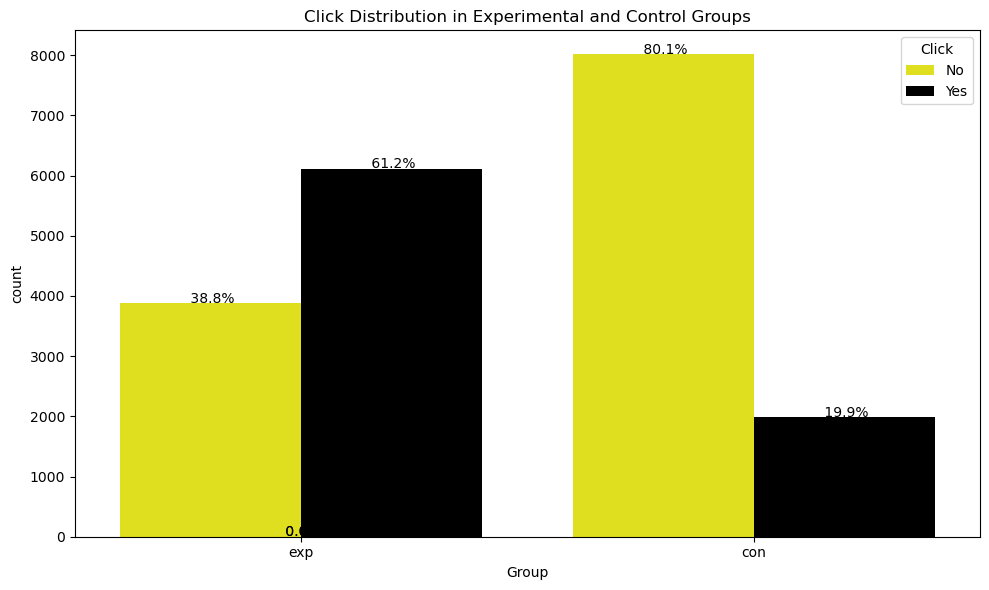

In [47]:
# Plot the data
palette = {0: 'yellow', 1: 'black'}
plt.figure(figsize = (10,6))
ax = sns.countplot(x='group', hue = 'click', data = data, palette = palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.legend(title='Click', labels=['No', 'Yes'])

#Calculate the percentages and annotate the bars
group_counts = data.groupby(['group']).size()
group_click_counts = data.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    #Find the group and click type for the current bar
    group = 'exp' if p.get_x() <0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height /total
    ax.text(p.get_x() + p.get_width() / 2., height + 5 , f'{percentage: .1f}%', ha ="center", color = 'black', fontsize=10)

plt.tight_layout()
plt.show()


In [89]:
# Separate the data from the two groups (sd stands for session duration)
experimental = data[data["group"]=="exp"]["click"]
control = data[data["group"]=="con"]["click"]

print(f"{len(experimental)} users click the 'Free Trial' button with an average CTR of {experimental.mean():.2f} \n")
print(f"{len(control)} users click the 'Enroll Now' button with an average CTR of {control.mean():.2f} ")

10000 users click the 'Free Trial' button with an average CTR of 0.61 

10000 users click the 'Enroll Now' button with an average CTR of 0.20 


In [51]:
@dataclass
class estimation_metrics_cont:
    n: int
    xbar: float
    s: float
        
    def __repr__(self):
        return f"sample_params(n={self.n}, xbar={self.xbar:.3f}, s={self.s:.3f})"

In [53]:
#compute_continuous_metrics
def compute_continuous_metrics(data):
    """Computes the relevant metrics out of a sample for continuous data.

    Args:
        data (pandas.core.series.Series): The sample data. In this case the average click for each user.

    Returns:
        estimation_metrics_cont: The metrics saved in a dataclass instance.
    """
    
    ### START CODE HERE ###
    metrics = estimation_metrics_cont( 
        n=len(data),
        xbar=np.mean(data),
        s=np.std(data, ddof=1)
    ) 
    ### END CODE HERE ###
    
    return metrics

In [57]:
# Test the code
experimental_metrics = compute_continuous_metrics(experimental)
print(f"n={experimental_metrics.n}, xbar={experimental_metrics.xbar:.2f} and s={experimental_metrics.s:.2f} for experimental data\n")

control_metrics = compute_continuous_metrics(control)
print(f"n={control_metrics.n}, xbar={control_metrics.xbar:.2f} and s={control_metrics.s:.2f} for control data")

n=10000, xbar=0.61 and s=0.49 for experimental data

n=10000, xbar=0.20 and s=0.40 for control data


In [59]:
#Degrees of freedom
def degrees_of_freedom(experimental_metrics, control_metrics):
    """Computes the degrees of freedom for two samples.

    Args:
        control_metrics (estimation_metrics_cont): The metrics for the control sample.
        variation_metrics (estimation_metrics_cont): The metrics for the variation sample.

    Returns:
        numpy.float: The degrees of freedom.
    """
    
    ### START CODE HERE ###
    
    n1, s1 = experimental_metrics.n, experimental_metrics.s
    n2, s2 = control_metrics.n, control_metrics.s
    
    
    dof = np.square(np.square(s1)/n1 + np.square(s2)/n2)/((np.square(np.square(s1)/n1))/(n1-1) + (np.square(np.square(s2)/n2))/(n2-1))
    
    ### END CODE HERE ###
    
    
    return dof

In [61]:
# Test your code
dof = degrees_of_freedom(experimental_metrics, control_metrics)
print(f"DoF for AB test samples: {dof:.2f}")

DoF for AB test samples: 19250.52


In [63]:
#t-statistic
def t_statistic_diff_means(experimental_metrics, control_metrics):
    """Compute the t-statistic for the difference of two means.

    Args:
        control_metrics (estimation_metrics_cont): The metrics for the control sample.
        variation_metrics (estimation_metrics_cont): The metrics for the variation sample.

    Returns:
        numpy.float: The value of the t-statistic.
    """
    
    ### START CODE HERE ###
    
    n1, xbar1, s1 = experimental_metrics.n,experimental_metrics.xbar, experimental_metrics.s
    n2, xbar2, s2 = control_metrics.n,control_metrics.xbar, control_metrics.s
    
    t = ((xbar1 - xbar2) - 0)/np.sqrt(np.square(s1)/n1 + np.square(s2)/n2)
    ### END CODE HERE ###
    
    return t

In [67]:
# Test the code
t = t_statistic_diff_means(experimental_metrics, control_metrics)
print(f"t statistic for AB test: {t:.2f}")

t statistic for AB test: 65.51


In [77]:
#Determine if you should reject (or not) the null hypothesis
#Compute the p-value given the degrees of freedom and multiply by 2 since this is a two-sided test.
#If the p-value is lower to alpha then you should reject the null hypothes

def reject_nh_t_statistic(t_statistic, dof, alpha=0.05):
    """Decide whether to reject (or not) the null hypothesis of the t-test.

    Args:
        t_statistic (numpy.float): The computed value of the t-statistic for the two samples.
        dof (numpy.float): The computed degrees of freedom for the two samples.
        alpha (float, optional): The desired level of significancy. Defaults to 0.05.

    Returns:
        bool: True if the null hypothesis should be rejected. False otherwise.
    """
    
    reject = False
    ### START CODE HERE ###
    p_value = 2*(1 - stats.t.cdf(abs(t_statistic), df=dof))
    
    if p_value < alpha:
        reject = True
    ### END CODE HERE ###
        
    return reject

In [79]:
# Test the code

alpha = 0.05
reject_nh = reject_nh_t_statistic(t, dof, alpha)

print(f"The null hypothesis can be rejected at the {alpha} level of significance: {reject_nh}\n")

msg = "" if reject_nh else " not"
print(f"There is{msg} enough statistical evidence against H0.\nIt can be concluded that there is{msg} a statistically significant difference between the means of the two samples.")

The null hypothesis can be rejected at the 0.05 level of significance: True

There is enough statistical evidence against H0.
It can be concluded that there is a statistically significant difference between the means of the two samples.


In [123]:
#Read the modified data set
data1 = pd.read_csv("ab_test_click_data_modified.csv")
data1.tail(10)

,user_id,click,group,timestamp
14988,14989,0,con,NaN
14989,14990,0,con,NaN
14990,14991,0,con,NaN
14991,14992,0,con,NaN
14992,14993,0,con,NaN
14993,14994,1,con,NaN
14994,14995,0,con,NaN
14995,14996,0,con,NaN
14996,14997,0,con,NaN
14997,14998,0,con,NaN


In [129]:
experimental_data = data1[data1["group"]=="exp"]["click"]
control_data = data1[data1["group"]=="con"]["click"]

print(f"{len(experimental_data)} users click the 'Free Trial' button with an average CTR of {experimental_data.mean():.4f} \n")
print(f"{len(control_data)} users click the 'Enroll Now' button with an average CTR of {control_data.mean():.4f} ")

10000 users click the 'Free Trial' button with an average CTR of 0.6116 

4998 users click the 'Enroll Now' button with an average CTR of 0.2021 


In [ ]:
## Compute proportion metrics
- $n$ stands for the number of users in the data
- $x$ stands for the number of users who converted in the data
- $p$ stands for CTR (users who click/total users)

In [131]:
@dataclass
class estimation_metrics_prop:
    n: int
    x: int
    p: float
        
    def __repr__(self):
        return f"sample_params(n={self.n}, x={self.x}, p={self.p:.3f})"

In [133]:

def compute_proportion_metrics(data1):
    """Computes the relevant metrics out of a sample for proportion-like data.

    Args:
        data (pandas.core.series.Series): The sample data. In this case 1 if the user converted and 0 otherwise.

    Returns:
        estimation_metrics_prop: The metrics saved in a dataclass instance.
    """
    
    ### START CODE HERE ###
    metrics = estimation_metrics_prop( 
        n=len(data1),
        x=data1.sum(),
        p=data1.mean()
    )
    ### END CODE HERE ###
    
    return metrics


In [148]:
experimental_metrics = compute_proportion_metrics(experimental_data)
print(f"n={experimental_metrics.n}, x={experimental_metrics.x} and p={experimental_metrics.p:.4f} for experimental data\n")

control_metrics = compute_proportion_metrics(control_data)
print(f"n={control_metrics.n}, x={control_metrics.x} and p={control_metrics.p:.4f} for control data")

n=10000, x=6116 and p=0.6116 for experimental data

n=4998, x=1010 and p=0.2021 for control data


## Estimate pooled_proportion

Now that you have a way of computing all necessary metrics for each sample it is time to create a way to compute the pooled proportion. For this fill the `pooled_proportion` function below. Notice that this function will receive two instances of the `estimation_metrics_prop` class.

Remember that the pooled proportion can be computed like this: 

$\hat{p} = \frac{x_1 + x_2}{n_1 + n_2}$

In [146]:
def pooled_proportion(control_metrics, variation_metrics):
    """Compute the pooled proportion for the two samples.

    Args:
        control_metrics (estimation_metrics_prop): The metrics for the control sample.
        variation_metrics (estimation_metrics_prop): The metrics for the variation sample.

    Returns:
        numpy.float: The pooled proportion.
    """
    
    ### START CODE HERE ###
    
    x1, n1 = experimental_metrics.x, experimental_metrics.n
    x2, n2 = control_metrics.x, control_metrics.n
    
    pp = (x1 + x2)/(n1 + n2)
    
    ### END CODE HERE ###
    
    return pp

In [141]:
# Test the code
pp = pooled_proportion(experimental_metrics, control_metrics)
print(f"pooled proportion for AB test samples: {pp:.4f}")

pooled proportion for AB test samples: 0.6116


## Calculate z-statistic

Now you have everything you need to calculate the z-statistic for the difference between proportions. Remember that this statistic can be computed like this:

$$ z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}$$

where $\hat{p}$ is the pooled proportion: $\hat{p} = \frac{x_1 + x_2}{n_1 + n_2}$

In [161]:
def z_statistic_diff_proportions(experimental_metrics, control_metrics):
    """Compute the z-statistic for the difference of two proportions.

    Args:
        experimental_metrics (estimation_metrics_prop): The metrics for the experimental sample.
        control_metrics (estimation_metrics_prop): The metrics for the control sample.

    Returns:
        numpy.float: The z-statistic.
    """
    
    ### START CODE HERE ###
    
    pp = pooled_proportion(experimental_metrics, control_metrics)
    
    n1, p1 = experimental_metrics.n, experimental_metrics.p
    n2, p2 = control_metrics.n, control_metrics.p
    
    z = (p1 - p2)/np.sqrt(pp*(1-pp)*(1/n1 + 1/n2))
    
    ### END CODE HERE ###
    
    
    return z

In [163]:
z = z_statistic_diff_proportions(experimental_metrics, control_metrics)
print(f"z statistic for AB test: {z:.4f}")

z statistic for AB test: 48.5045


In [165]:
def reject_nh_z_statistic(z_statistic, alpha):
    """Decide whether to reject (or not) the null hypothesis of the z-test.

    Args:
        z_statistic (numpy.float): The computed value of the z-statistic for the two proportions.
        alpha (float, optional): The desired level of significancy. Defaults to 0.05.

    Returns:
        bool: True if the null hypothesis should be rejected. False otherwise.
    """
    
    reject = False
    ### START CODE HERE ###
    p_value = 2*(1-stats.norm.cdf(abs(z_statistic)))
    
    if p_value < alpha:
        reject = True
    ### END CODE HERE ###
        
    return reject

In [167]:
alpha = 0.05
reject_nh = reject_nh_z_statistic(z, alpha)

print(f"The null hypothesis can be rejected at the {alpha} level of significance: {reject_nh}\n")

msg = "" if reject_nh else " not"
print(f"There is{msg} enough statistical evidence against H0.\nThus it can be concluded that there is{msg} a statistically significant difference between the two proportions.")

The null hypothesis can be rejected at the 0.05 level of significance: True

There is enough statistical evidence against H0.
Thus it can be concluded that there is a statistically significant difference between the two proportions.


## Confidence Interval

Create confidence intervals for the CTRs of each of the two groups. Can compute such an interval for a proportion like this:

$$ \hat{p} \pm z_{1-\alpha/2} \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$$

Complete the `confidence_interval_proportion` function below. This function will receive the metrics of one of the groups and should return the lower and upper values of the confidence interval.


In [178]:
def confidence_interval_proportion(metrics, alpha=0.05):
    """Compute the confidende interval for a proportion-like sample.

    Args:
        metrics (estimation_metrics_prop): The metrics for the sample.
        alpha (float, optional): The desired level of significance. Defaults to 0.05.

    Returns:
        (numpy.float, numpy.float): The lower and upper bounds of the confidence interval.
    """
    
    ### START CODE HERE ###
    n, p = metrics.n, metrics.p
    
    distance = stats.norm.ppf(1-alpha/2)*np.sqrt(p*(1-p)/n)
    
    lower = p - distance
    upper = p + distance
    ### END CODE HERE ###
    
    return lower, upper

In [184]:
e_lower, e_upper = confidence_interval_proportion(experimental_metrics)
print(f"Confidence interval for experimental group: [{e_lower:.3f}, {e_upper:.3f}]\n")

c_lower, c_upper = confidence_interval_proportion(control_metrics)
print(f"Confidence interval for control group: [{c_lower:.3f}, {c_upper:.3f}]")

Confidence interval for experimental group: [0.602, 0.621]

Confidence interval for control group: [0.191, 0.213]


In [188]:
#Testing for Practical Significance in A/B Testing
def is_practically_significant(delta, lower_bound_CI):
    """
    Assess if the difference between the control and experimental significant using the minimum detectable effect (MDE)
    Arguments:
    -delta (float): Minimum Detectable Effect (MDE) considered for practical significant
    
    Returns:
    -Prints whether the experiment has practical significance based on MDE and CI
    """

    # Check if the lower bound of CI is greater than or equal to delta
    
    if  lower_bound_CI >= delta:
        print(f"The difference between control and experimental group is practically significant")
        There is a practical (large enough) significance; the control group is higher than the experimental group
        return True
    else:
        print("We don't have practical significance!")
        return False


In [196]:
#Call the function
delta=0.1 #Minimum Detectable Effect
significance_control = is_practically_significant(delta, c_lower)
print(f"Lower Bound of 95% confidence interval for control group is: {c_lower:.3f}")

The difference between control and experimental group is practically significant
Lower Bound of 95% confidence interval for experimental group is: 0.602

The difference between control and experimental group is practically significant
Lower Bound of 95% confidence interval for control group is: 0.191
